In [112]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd

In [89]:
#Возвращает значение полинома вида kind степени n в точке x
def polynomial(n: int, x: float, kind: str):
    #моном
    if (kind == 'monom'):
        return x**n
    #Полином Чебышева
    elif (kind == 'Chebyshev'):
        if(n == 0) :
            return 1
        elif (n == 1) :
            return x
        else:
            return 2*x*polynomial(n-1, x, kind) - polynomial(n -2, x, kind)
    #Полином Лежандра
    elif (kind == 'Legendre'):
        if (n == 0):
            return 1
        elif (n == 1):
            return x
        else:
            return (2*n -1) / n*x*polynomial(n-1, x, kind) - (n-1) / n * polynomial(n-2, x, kind)

In [90]:
def setMatrix(n: int, data, kind: str):
    A = np.zeros((len(data), n + 1))
    b = np.zeros(len(data))
    
    for i in range(len(data)):
        for j in range(n + 1):
            A[i, j] = polynomial(j, data[i, 0], kind)
        b[i] = data[i, 1]
    return A, b

In [91]:
def dataApproxWithNU(n: int, data, kind: str):
    A, b = setMatrix(n, data, kind)
    
    t1 = perf_counter()
    AtA = np.dot(A.T, A)
    Atb = np.dot(A.T, b)
    
    cond = np.linalg.cond(AtA)
    
    coeffs = np.linalg.solve(AtA, Atb)
    t2 = perf_counter()
    bench = t2 - t1
    
    NRSME = np.sqrt(np.sum((np.dot(A, coeffs) - b)**2) / len(data)) / np.max(np.abs(b))
    
    return np.dot(A, coeffs), cond, RSME, bench

In [92]:
def householderReflectionQR(A):
    n, m = A.shape
    Q = np.eye(n)
    R = np.copy(A)
    
    for k in range(m):
        v = np.copy(R[k:, k]).reshape((n-k, 1))
        v[0] = v[0] + np.sign(v[0]) * np.linalg.norm(v)
        
        v = v / np.linalg.norm(v)
        R[k:, k:] = R[k:, k:] - 2 * v @ v.T @ R[k:, k:]
        Q[k:] = Q[k:] - 2 * v @ v.T @ Q[k:]
    
    return Q[:m].T, R[:m]

In [93]:
def dataApproxWithQR(n: int, data, kind: str):
    A, b = setMatrix(n, data, kind)
    
    t1 = perf_counter()
    Q, R = householderReflectionQR(A)
    t2 = perf_counter()
    bench = t2 - t1
    
    cond = np.linalg.cond(A)
    
    coeffs = np.dot(np.linalg.inv(R), np.dot(Q.T, b))
    
    NRSME = np.sqrt(np.sum((np.dot(A, coeffs) - b)**2) / len(data)) / np.max(np.abs(b))
    
    return np.dot(A, coeffs), cond, RSME, bench

In [204]:
def plotData(data, approxData, n):
    fig = plt.figure(figsize=(12,8), frameon=True)
    plt.style.use('ggplot')
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['font.size'] = 37
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    ax = fig.add_subplot(111)    

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.set(facecolor='w')
    ax.grid('axis = "both"', color = 'gray')

    ax.set_xlabel('$x$', labelpad = -10)
    ax.set_ylabel('$y$', rotation = 0, labelpad = 20)
    
    ax.plot(data[:,0], data[:,1], color = 'blue', linestyle = '-', linewidth = 3, label='Данные')
    ax.plot(data[:,0], approxData, color = 'red', linestyle = '-', linewidth = 2, label = 'Приближение при N = ' + str(n))
    ax.legend(loc=4)

    plt.show()

In [95]:
path = 'data_2.txt'
data = np.loadtxt(path, dtype=float)

In [108]:
N = 10
condAtA = np.zeros(N)
condA = np.zeros(N)
NU_NRSME = np.zeros(N)
QR_NRSME = np.zeros(N)
NU_time = np.zeros(N)
QR_time = np.zeros(N)

for n in range(N):
    _, cond, NRSME, bench = dataApproxWithNU(n+1, data, 'Chebyshev')
    condAtA[n] = cond
    NU_NRSME[n] = NRSME
    NU_time[n] = bench 
    
    _, cond, NRSME, bench = dataApproxWithQR(n+1, data, 'Chebyshev')
    condA[n] = cond
    QR_NRSME[n] = NRSME
    QR_time[n] = bench 

In [199]:
table = pd.DataFrame({'cond(AtA)': condAtA, 'NRMSE (НУ)': NU_NRSME, 'Время НУ (с)': NU_time,
                     'cond(A)': condA, 'NRMSE (QR)': QR_NRSME, 'Время QR (с)': QR_time}, index=np.arange(1, 11))
table["cond(AtA)"] = table["cond(AtA)"].map("{:.2e}".format)
table["NRMSE (НУ)"] = table["NRMSE (НУ)"].map("{:.2e}".format)
table["Время НУ (с)"] = table["Время НУ (с)"].map("{:.2e}".format)
table["cond(A)"] = table["cond(A)"].map("{:.2e}".format)
table["NRMSE (QR)"] = table["NRMSE (QR)"].map("{:.2e}".format)
table["Время QR (с)"] = table["Время QR (с)"].map("{:.2e}".format)

In [200]:
table

,cond(AtA),NRMSE (НУ),Время НУ (с),cond(A),NRMSE (QR),Время QR (с)
1,3.06e+02,1.14e-02,4.85e-04,1.75e+01,1.14e-02,1.69e+01
2,1.19e+05,6.72e-04,3.61e-04,3.45e+02,6.72e-04,2.84e+01
3,6.13e+07,6.69e-04,3.40e-04,7.83e+03,6.69e-04,4.59e+01
4,2.61e+10,6.66e-04,1.43e-03,1.62e+05,6.66e-04,6.92e+01
5,1.39e+13,4.41e-04,3.53e-03,3.73e+06,4.41e-04,9.05e+01
6,6.11e+15,2.52e-04,8.36e-03,7.80e+07,2.47e-04,9.62e+01
7,1.68e+17,2.41e-04,2.81e-03,1.80e+09,2.36e-04,8.57e+01
8,2.61e+17,2.53e-04,6.51e-03,3.78e+10,2.03e-04,9.77e+01
9,3.60e+17,2.38e-04,6.54e-03,8.71e+11,1.80e-04,2.83e+02
10,2.41e+17,2.37e-04,6.59e-03,1.83e+13,1.67e-04,2.63e+02


In [201]:
table.to_csv('data2_res.csv')

In [202]:
NU_NRSME

array([0.0114233 , 0.00067195, 0.00066935, 0.00066629, 0.00044069,
       0.00025218, 0.00024124, 0.00025312, 0.00023828, 0.00023699])

In [203]:
QR_NRSME

array([0.0114233 , 0.00067195, 0.00066935, 0.00066629, 0.00044069,
       0.00024673, 0.0002362 , 0.00020257, 0.00017991, 0.0001665 ])

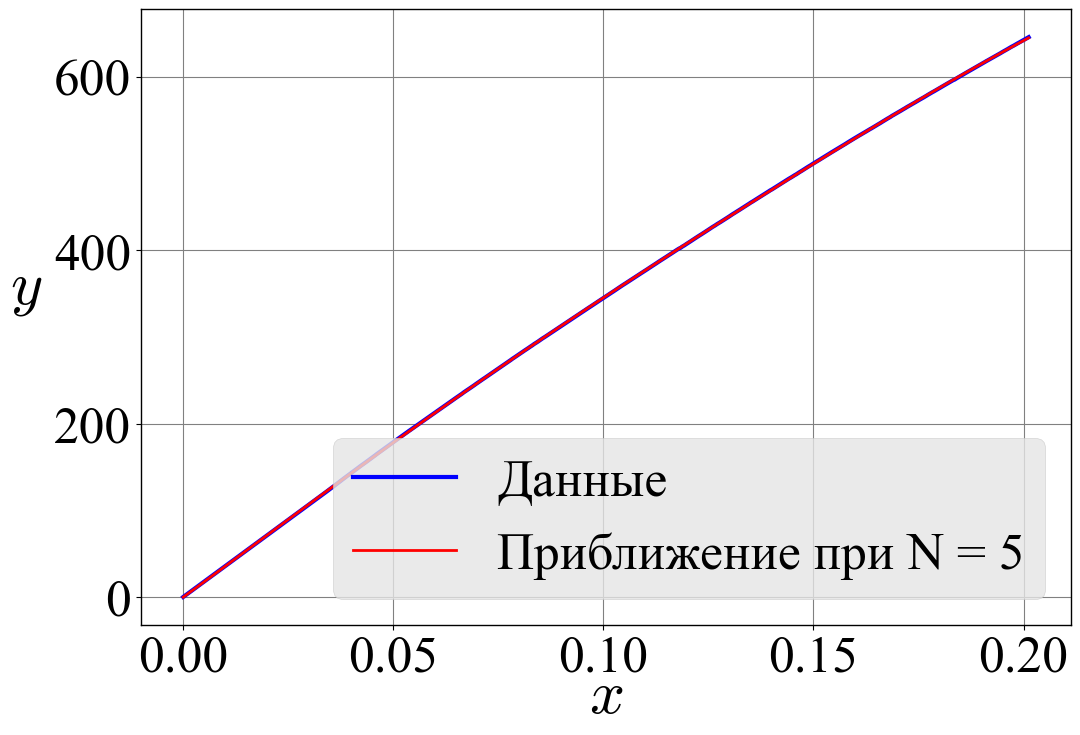

In [206]:
n = 5
sol, cond, NRSME, bench = dataApproxWithQR(n, data, 'Chebyshev')
plotData(data, sol, n)

In [218]:
path = 'task1/data_4.txt'
data = np.loadtxt(path, dtype=float)

N = 10
condAtA = np.zeros(N)
condA = np.zeros(N)
NU_NRSME = np.zeros(N)
QR_NRSME = np.zeros(N)
NU_time = np.zeros(N)
QR_time = np.zeros(N)

for n in range(N):
    _, cond, NRSME, bench = dataApproxWithNU(n+1, data, 'Chebyshev')
    condAtA[n] = cond
    NU_NRSME[n] = NRSME
    NU_time[n] = bench 
    
    _, cond, NRSME, bench = dataApproxWithQR(n+1, data, 'Chebyshev')
    condA[n] = cond
    QR_NRSME[n] = NRSME
    QR_time[n] = bench 

In [219]:
table = pd.DataFrame({'cond(AtA)': condAtA, 'NRMSE (НУ)': NU_NRSME, 'Время НУ (с)': NU_time,
                     'cond(A)': condA, 'NRMSE (QR)': QR_NRSME, 'Время QR (с)': QR_time}, index=np.arange(1, 11))
table["cond(AtA)"] = table["cond(AtA)"].map("{:.2e}".format)
table["NRMSE (НУ)"] = table["NRMSE (НУ)"].map("{:.2e}".format)
table["Время НУ (с)"] = table["Время НУ (с)"].map("{:.2e}".format)
table["cond(A)"] = table["cond(A)"].map("{:.2e}".format)
table["NRMSE (QR)"] = table["NRMSE (QR)"].map("{:.2e}".format)
table["Время QR (с)"] = table["Время QR (с)"].map("{:.2e}".format)

In [220]:
table

,cond(AtA),NRMSE (НУ),Время НУ (с),cond(A),NRMSE (QR),Время QR (с)
1,1.92e+01,2.76e-02,1.10e-03,4.39e+00,2.76e-02,1.37e-01
2,4.32e+02,2.32e-03,1.79e-04,2.08e+01,2.32e-03,1.63e-01
3,1.50e+04,1.46e-04,1.31e-03,1.22e+02,1.46e-04,2.12e-01
4,4.48e+05,7.32e-06,1.96e-04,6.69e+02,7.32e-06,2.71e-01
5,1.42e+07,3.06e-07,1.10e-03,3.77e+03,3.06e-07,4.82e-01
6,4.46e+08,1.09e-08,2.83e-04,2.11e+04,1.09e-08,6.36e-01
7,1.43e+10,3.43e-10,2.16e-04,1.19e+05,3.43e-10,4.71e-01
8,4.58e+11,5.71e-11,2.68e-04,6.77e+05,9.54e-12,5.36e-01
9,1.48e+13,2.95e-10,2.84e-04,3.84e+06,2.39e-13,5.51e-01
10,4.65e+14,8.99e-10,2.91e-04,2.19e+07,5.46e-15,5.97e-01


In [221]:
table.to_csv('data5_res.csv')

In [278]:
path = 'task1/data_5.txt'
data = np.loadtxt(path, dtype=float)

n = 0
sol1, cond, NRSME, bench = dataApproxWithQR(n, data, 'Chebyshev')

In [279]:
cond, NRSME, bench

(1.0, 0.2937920461908052, 0.08954577497206628)

In [280]:
print("{:.2e}".format(bench))

8.95e-02


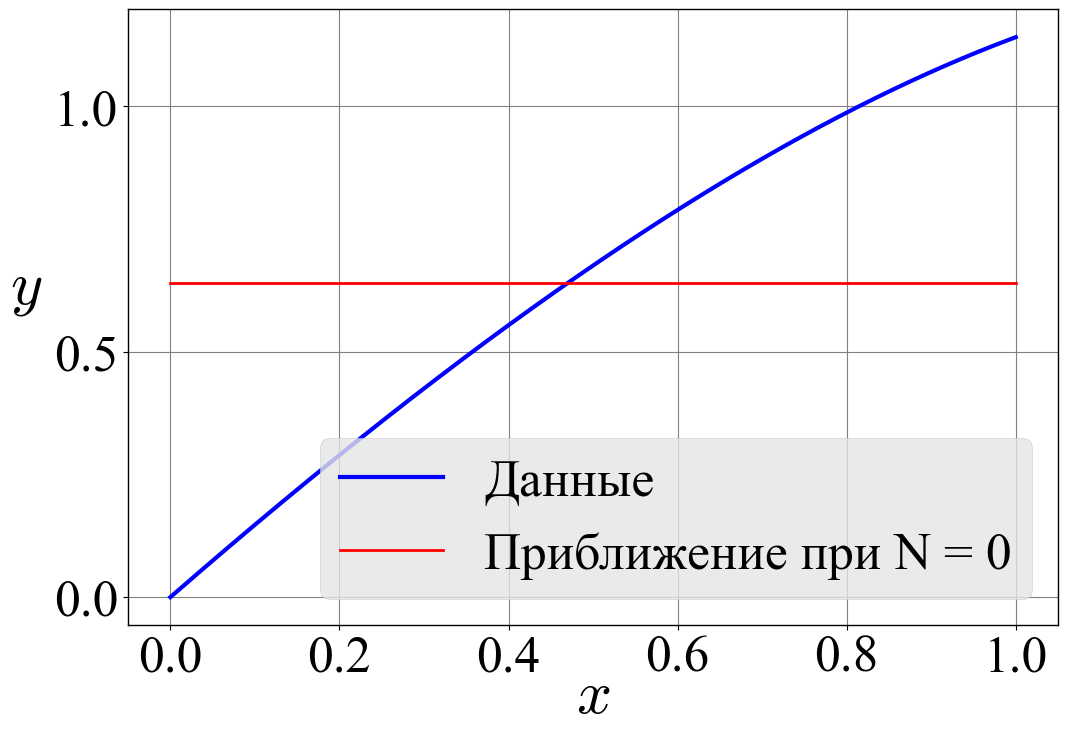

In [281]:
plotData(data, sol1, n)

7.222513139015064

In [282]:
x = np.array([1 + np.sqrt(35), 3, 5])

In [288]:
householderReflectionQR(np.array([[1, 2], [3, 4], [5, 6]]))

(array([[-0.02857143, -0.51428571],
        [-0.51428571,  0.74285714],
        [-0.85714286, -0.42857143]]),
 array([[-5, -7],
        [ 0,  0]]))

In [289]:
A = np.arange(1, 7).reshape(3, 2)

In [290]:
A

array([[1, 2],
       [3, 4],
       [5, 6]])

In [291]:
np.linalg.qr(A)

(array([[-0.16903085,  0.89708523],
        [-0.50709255,  0.27602622],
        [-0.84515425, -0.34503278]]),
 array([[-5.91607978, -7.43735744],
        [ 0.        ,  0.82807867]]))